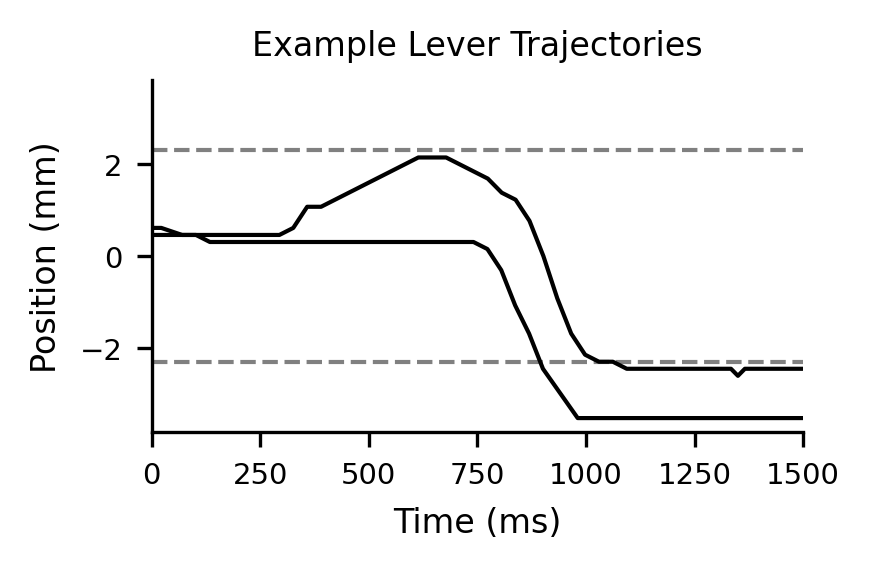

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = './data/pull_mid_trials_data.csv'
try:
    plot_data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File '{file_path}' Not Found")

fig, ax = plt.subplots(figsize=(3.0, 2.0), dpi=300)

ax.set_title('Example Lever Trajectories', fontsize=8)

plot_color = 'black'

radius_mm = 30
y1_transformed = (687 - 672) * 300 / 1024 * (np.pi / 180) * radius_mm
y2_transformed = (657 - 672) * 300 / 1024 * (np.pi / 180) * radius_mm
ax.axhline(y=y1_transformed, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=y2_transformed, color='gray', linestyle='--', linewidth=1)

if 'plot_data' in locals() and not plot_data.empty:
    for (session, trial), trial_group in plot_data.groupby(['session_idx', 'trial_id']):
        trial_group = trial_group.sort_values(by='time_ms')
        ax.plot(trial_group['time_ms'], trial_group['angle_deg'] * (np.pi / 180) * radius_mm, color=plot_color, linewidth=1)

ylim_low = (647 - 672) * 300 / 1024 * (np.pi / 180) * radius_mm
ylim_high = (697 - 672) * 300 / 1024 * (np.pi / 180) * radius_mm
ax.set_ylim([ylim_low, ylim_high])

ax.set_xlim([0, 1500])

ax.set_xlabel('Time (ms)', fontsize=8)
ax.set_ylabel('Position (mm)', fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=7)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig("pull_mid_trials.svg", format="svg", bbox_inches='tight')

plt.show()

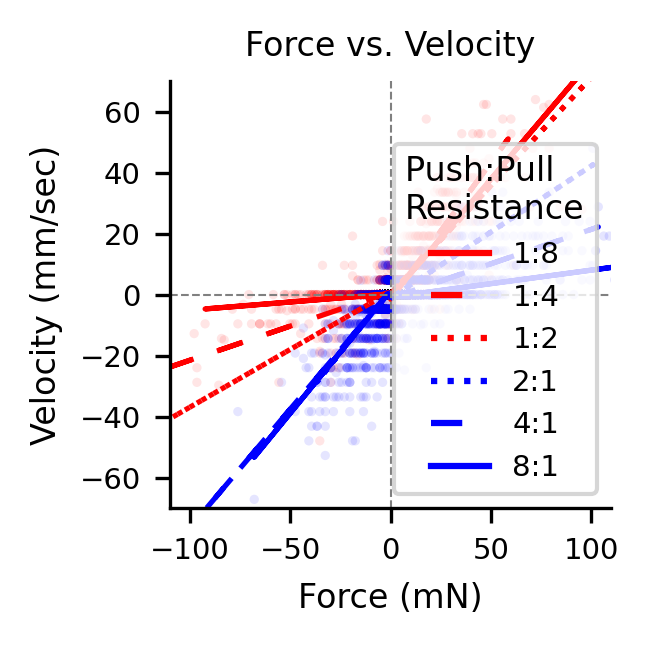

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_filename = './data/force_velocity_plot_data.csv'

# --- 1. Load the pre-processed data from CSV ---
plot_df = pd.read_csv(csv_filename)

# --- 2. Define Plotting Styles ---
style_map = {
    (8, 64): {'color': 'red', 'linestyle': '-', 'label': '1:8'},
    (8, 32): {'color': 'red', 'linestyle': (0, (5, 5)), 'label': '1:4'},
    (8, 16): {'color': 'red', 'linestyle': ':', 'label': '1:2'},
    (16, 8): {'color': 'blue', 'linestyle': ':', 'label': '2:1'},
    (32, 8): {'color': 'blue', 'linestyle': (0, (5, 5)), 'label': '4:1'},
    (64, 8): {'color': 'blue', 'linestyle': '-', 'label': '8:1'},
}
# Define the display order for the legend
legend_order = [(8, 64), (8, 32), (8, 16), (16, 8), (32, 8), (64, 8)]

# --- 3. Create the plot ---
fig, ax = plt.subplots(figsize=(2.25, 2.25), dpi=300)

push_light_data = plot_df[plot_df['push resistance'] < plot_df['pull resistance']]
ax.scatter(push_light_data['force'], push_light_data['linear_velocity_next_step'],
            color='red', alpha=0.1, s=5, edgecolors='none')
pull_light_data = plot_df[plot_df['push resistance'] > plot_df['pull resistance']]
ax.scatter(pull_light_data['force'], pull_light_data['linear_velocity_next_step'],
            color='blue', alpha=0.1, s=5, edgecolors='none')

# Plot regression lines
legend_handles = []
legend_labels = []

for p_res, l_res in legend_order:
    style_key = (p_res, l_res)
    if style_key not in style_map: continue

    style = style_map[style_key]

    # Extract all data for this resistance combination
    condition_df = plot_df[(plot_df['push resistance'] == p_res) & (plot_df['pull resistance'] == l_res)]

    if len(condition_df) > 1:
        # Plot regression lines separately for positive and negative force
        for is_pos in [True, False]:
            subset = condition_df[condition_df['force_positive'] == is_pos]
            if len(subset) > 1:
                slope, intercept = np.polyfit(subset['force'], subset['linear_velocity_next_step'], 1)
                line, = ax.plot(
                    subset['force'],
                    slope * subset['force'] + intercept,
                    color=style['color'],
                    linestyle=style['linestyle'],
                    linewidth=1.25
                )

        proxy_line = plt.Line2D([], [], color=style['color'], linestyle=style['linestyle'], linewidth=1.5)
        legend_handles.append(proxy_line)
        legend_labels.append(f"{style['label']}")


# --- 4. Finalize the plot ---
ax.legend(handles=legend_handles, labels=legend_labels, title="Push:Pull \nResistance", fontsize=7, title_fontsize=8)
ax.set_title('Force vs. Velocity', fontsize=8)
ax.set_xlabel('Force (mN)', fontsize=8)
ax.set_ylabel('Velocity (mm/sec)', fontsize=8)

ax.set_xlim(-110, 110)
ax.set_ylim(-70, 70)

ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.axhline(0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(0, color='grey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("force_velocity_plot.svg", format="svg", bbox_inches='tight')
plt.show()

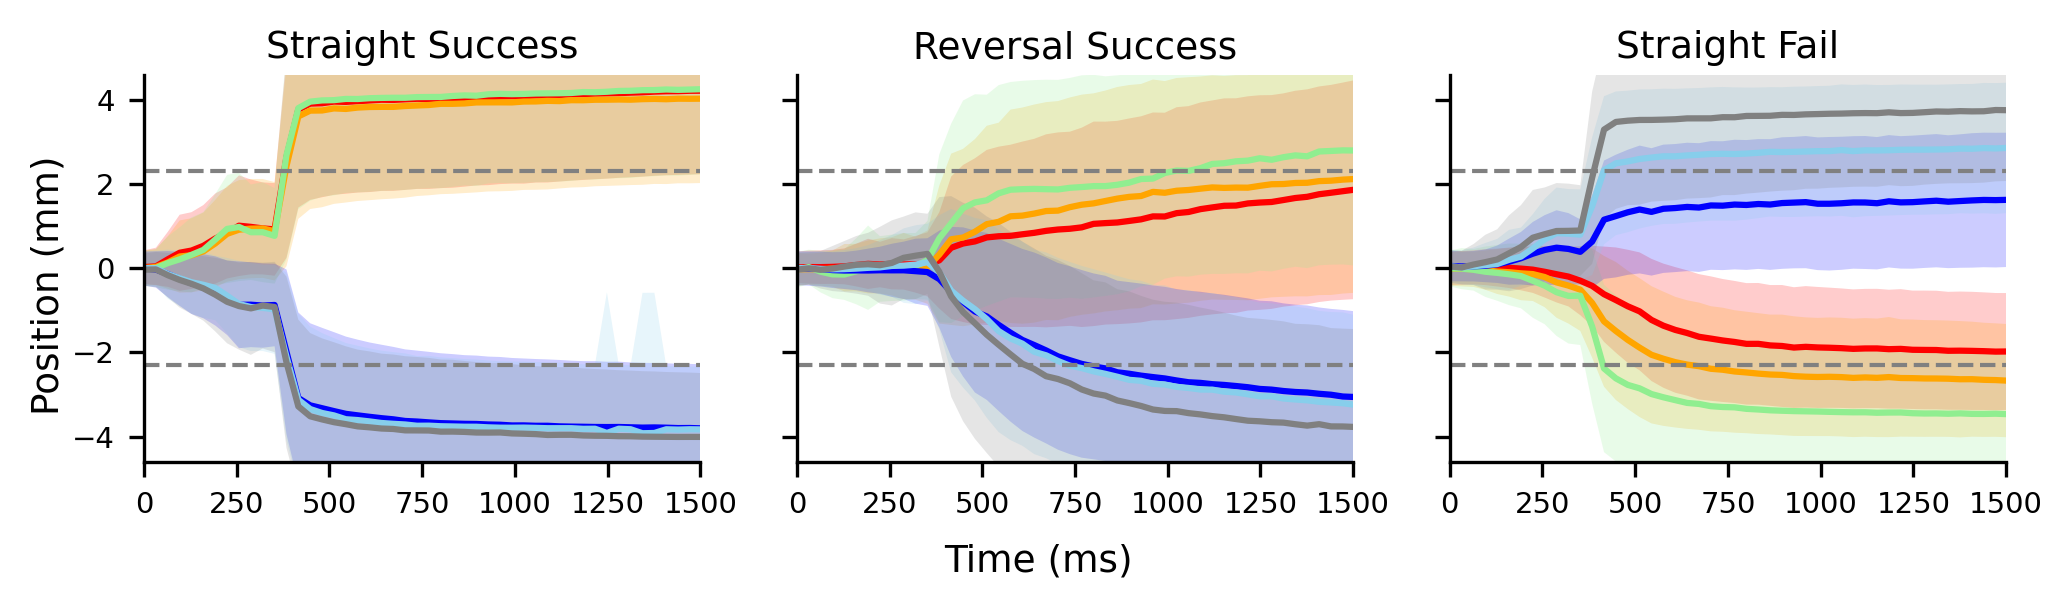

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = './data/plot_data_mean_std.csv'

categories = ['No CoM & Success', 'CoM & Success', 'CoM & Fail']
display_name = ['Straight Success', 'Reversal Success', 'Straight Fail']
original_labels = ['Push_Easy', 'Push_Mid', 'Push_Hard', 'Pull_Easy', 'Pull_Mid', 'Pull_Hard']
new_labels = ["1:8", "1:4", "1:2", "2:1", "4:1", "8:1"]
colors = ['red', 'orange', 'lightgreen', 'blue', 'skyblue', 'gray']

try:
    plot_data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File '{file_path}' Not Found.")
    exit()

fig, axes = plt.subplots(1, 3, figsize=(7, 2), dpi=300, sharey=True)

for idx, category_name in enumerate(categories):
    ax = axes[idx]
    clean_category_name = category_name.replace(' & ', '_').replace(' ', '_')

    for i, condition_label in enumerate(original_labels):
        mean_col = f"{clean_category_name}_{condition_label}_mean"
        std_col = f"{clean_category_name}_{condition_label}_std"

        if mean_col in plot_data.columns and std_col in plot_data.columns:

            subset = plot_data[['time_bin', mean_col, std_col]].dropna()

            time_bins = subset['time_bin']
            mean_values = subset[mean_col] * (np.pi / 180) * radius_mm
            std_values = subset[std_col] * (np.pi / 180) * radius_mm

            ax.fill_between(time_bins,
                            mean_values - std_values,
                            mean_values + std_values,
                            color=colors[i],
                            alpha=0.2,
                            edgecolor=None)

            ax.plot(time_bins, mean_values, color=colors[i], linewidth=1.5, label=new_labels[i])

    ax.set_title(display_name[idx], fontsize=9, pad=4)

    y1_transformed = (687 - 672) * 300 / 1024 * (np.pi / 180) * radius_mm
    y2_transformed = (657 - 672) * 300 / 1024 * (np.pi / 180) * radius_mm
    ax.axhline(y=y1_transformed, color='gray', linestyle='--', linewidth=1)
    ax.axhline(y=y2_transformed, color='gray', linestyle='--', linewidth=1)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.tick_params(axis='both', which='major', labelsize=7)


ylim_low = (642 - 672) * 300 / 1024 * (np.pi / 180) * radius_mm
ylim_high = (702 - 672) * 300 / 1024 * (np.pi / 180) * radius_mm
plt.setp(axes, xlim=[0, 1500], ylim=[ylim_low, ylim_high])

fig.supxlabel('Time (ms)', fontsize=9)
fig.supylabel('Position (mm)', fontsize=9)

plt.tight_layout(rect=[-0.02, -0.1, 1, 1])

output_filename = "trajectories_from_data.svg"
plt.savefig(output_filename, format="svg")

plt.show()

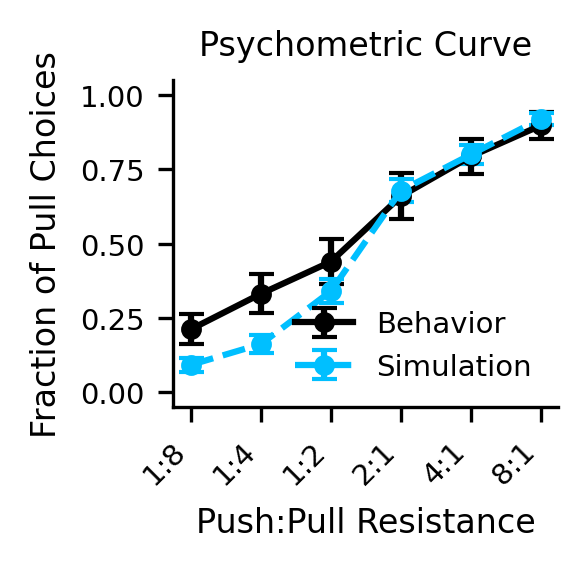

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

behavior_file = './data/psychometric_plot_data.csv'
simulation_file = './data/simulation_psychometric_data_MAP_CI.csv'

try:
    behavior_df = pd.read_csv(behavior_file)
    simulation_df = pd.read_csv(simulation_file)
except FileNotFoundError as e:
    print(f"Error: File Not Found. {e}")
    exit()

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

categories = behavior_df['Category']
x = np.arange(len(categories))
xticklabels = ['1:8','1:4','1:2','2:1','4:1','8:1']

ax.errorbar(x, behavior_df['Mean'],yerr=behavior_df['SEM']*1.96,
            fmt='-o',
            color='black',
            linewidth=1.5,
            markersize=4,
            capsize=3,
            label='Behavior')

ax.errorbar(x, simulation_df['Mean'], yerr=simulation_df['CI'],
            fmt='--o',
            color='deepskyblue',
            linewidth=1.5,
            markersize=4,
            capsize=3,
            label='Simulation')

ax.set_ylabel('Fraction of Pull Choices', fontsize=8)
ax.set_xlabel('Push:Pull Resistance', fontsize=8)
ax.set_title('Psychometric Curve', fontsize=8)
ax.set_xticks(x)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False, fontsize=7)

plt.tight_layout()
plt.savefig("comparison_psychometric_curve_CI.svg", format="svg", bbox_inches='tight')
plt.show()

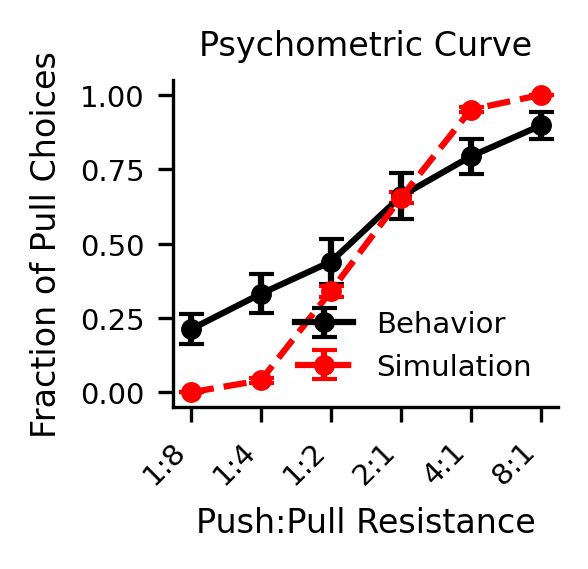

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

behavior_file = './data/psychometric_plot_data.csv'
simulation_file = './data/behavior_psychometric_data_CI.csv'

try:
    behavior_df = pd.read_csv(behavior_file)
    simulation_df = pd.read_csv(simulation_file)
except FileNotFoundError as e:
    print(f"Error: File Not Found. {e}")
    exit()

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

categories = behavior_df['Category']
xticklabels = ['1:8','1:4','1:2','2:1','4:1','8:1']
x = np.arange(len(categories))

ax.errorbar(x, behavior_df['Mean'],yerr=behavior_df['SEM']*1.96,
            fmt='-o',
            color='black',
            linewidth=1.5,
            markersize=4,
            capsize=3,
            label='Behavior')

ax.errorbar(x, simulation_df['mean'], yerr=simulation_df['CI_accuracy'],
            fmt='--o',
            color='red',
            linewidth=1.5,
            markersize=4,
            capsize=3,
            label='Simulation')

ax.set_xlabel('Push:Pull Resistance', fontsize=8)
ax.set_ylabel('Fraction of Pull Choices', fontsize=8)
ax.set_title('Psychometric Curve', fontsize=8)
ax.set_xticks(x)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(frameon=False, fontsize=7)

plt.tight_layout()
plt.savefig("comparison_psychometric_curve_CAI_CI.svg", format="svg", bbox_inches='tight')
plt.show()

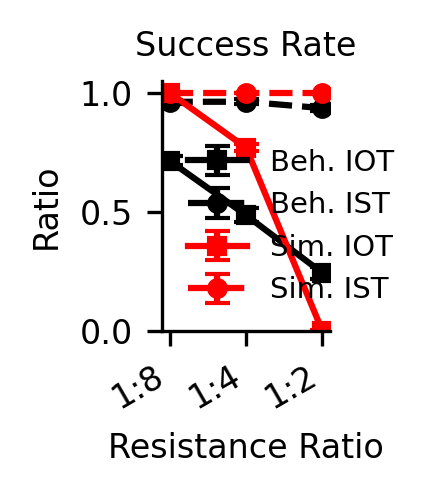

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

try:
    com_rate_df = pd.read_csv('./data/success_rate_com_vs_no_com_force.csv')
    after_error_df = pd.read_csv('./data/analysis_lucky_unlucky_success_CI.csv')
except FileNotFoundError as e:
    print(f"Error: File Not Found. {e}")
    exit()

difficulty_labels = ['Easy','Mid','Diff']
xtick_labels = ['1:8', '1:4', '1:2']
x = np.arange(len(difficulty_labels))

com_pivot = com_rate_df.pivot(index='Difficulty', columns='Condition', values='Success_Rate')
sem_pivot = com_rate_df.pivot(index='Difficulty', columns='Condition', values='SEM_Success_Rate')
com_pivot = com_pivot.reindex(difficulty_labels)
sem_pivot = sem_pivot.reindex(difficulty_labels)
com_success_rate = com_pivot['COM_force_success_rate']
wo_com_success_rate = com_pivot['wo_COM_force_success_rate']
CI_com_success_rate = sem_pivot['COM_force_success_rate']*1.96
CI_wo_com_success_rate = sem_pivot['wo_COM_force_success_rate']*1.96


after_error_df = after_error_df.set_index('Difficulty').reindex(difficulty_labels)
success_after_error = after_error_df['Success_Rate_After_Error']
success_lucky = after_error_df['Success_Rate_Lucky']
CI_Success_Rate_After_Error = after_error_df['CI_Success_Rate_After_Error']
CI_Success_Rate_Lucky = after_error_df['CI_Success_Rate_Lucky']

fig, ax = plt.subplots(figsize=(1.3, 1.75), dpi=300)

ax.errorbar(x, com_success_rate, yerr=CI_com_success_rate, color='black', linestyle='-', marker='s', markersize=4, label='Beh. IOT', capsize=3, linewidth=1.5)
ax.errorbar(x, wo_com_success_rate, yerr=CI_wo_com_success_rate, color='black', linestyle='--', marker='o', markersize=4, label='Beh. IST', capsize=3, linewidth=1.5)
ax.errorbar(x, success_after_error, yerr=CI_Success_Rate_After_Error, color='red', linestyle='-', marker='s', markersize=4, label='Sim. IOT', capsize=3, linewidth=1.5)
ax.errorbar(x, success_lucky, yerr=CI_Success_Rate_Lucky, color='red', linestyle='--', marker='o', markersize=4, label='Sim. IST', capsize=3, linewidth=1.5)

ax.set_title('Success Rate', fontsize=8)
ax.set_ylabel('Ratio', fontsize=8)
ax.set_xlabel('Resistance Ratio', fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=30, ha='right')

ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.set_ylim(0, 1.05)

ax.spines[['top', 'right']].set_visible(False)
ax.grid(False)

ax.legend(fontsize=7, frameon=False, loc='best')


plt.tight_layout()
plt.savefig("comparison_all_ratios_line_plot_CI.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()


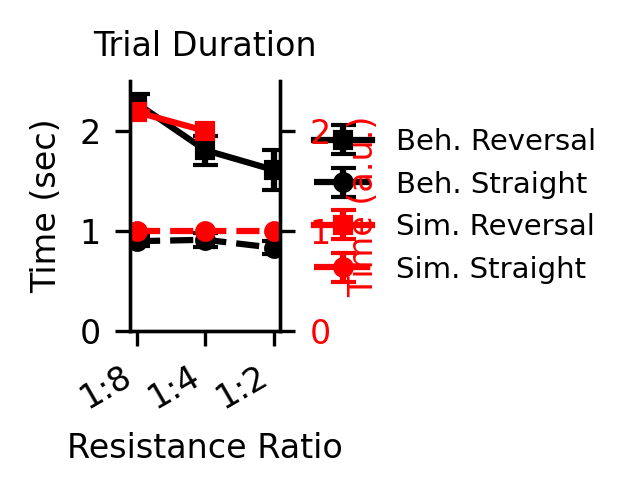

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

try:
    initial_error_df = pd.read_csv('./data/success_duration_by_initial_error_CI.csv')
    com_force_df = pd.read_csv('./data/duration_com_vs_no_com_force.csv')
except FileNotFoundError as e:
    print(f"Error: File Not Found. {e}")
    exit()

difficulty_labels = ['Easy','Mid','Diff']
xtick_labels = ['1:8', '1:4', '1:2']
x = np.arange(len(difficulty_labels))

no_error_duration_mean = initial_error_df['Mean_Duration_No_Error']
no_error_duration_sem = initial_error_df['CI_Duration_No_Error']
with_error_duration_mean = initial_error_df['Mean_Duration_With_Error']
with_error_duration_sem = initial_error_df['CI_Duration_With_Error']

com_force_pivot_mean = com_force_df.pivot(index='Difficulty', columns='Condition', values='Mean_Duration').reindex(difficulty_labels)
com_force_pivot_sem = com_force_df.pivot(index='Difficulty', columns='Condition', values='SEM_Duration').reindex(difficulty_labels)

wo_com_duration_mean = com_force_pivot_mean['wo_COM_force_success_duration']
wo_com_duration_sem = com_force_pivot_sem['wo_COM_force_success_duration']
com_duration_mean = com_force_pivot_mean['COM_force_success_duration']
com_duration_sem = com_force_pivot_sem['COM_force_success_duration']

fig, ax = plt.subplots(figsize=(2.4, 1.75), dpi=300)
ax2 = ax.twinx()

ax.errorbar(x, com_duration_mean/1000, yerr=com_duration_sem*1.96/1000, color='black', linestyle='-', marker='s', markersize=4, label='Beh. Reversal', capsize=3, linewidth=1.5)
ax.errorbar(x, wo_com_duration_mean/1000, yerr=wo_com_duration_sem*1.96/1000, color='black', linestyle='--', marker='o', markersize=4, label='Beh. Straight', capsize=3, linewidth=1.5)

ax2.errorbar(x, with_error_duration_mean, yerr=with_error_duration_sem, color='red', linestyle='-', marker='s', markersize=4, label='Sim. Reversal', capsize=3, linewidth=1.5)
ax2.errorbar(x, no_error_duration_mean, yerr=no_error_duration_sem, color='red', linestyle='--', marker='o', markersize=4, label='Sim. Straight', capsize=3, linewidth=1.5)

ax.set_title('Trial Duration', fontsize=8)
ax.set_ylabel('Time (sec)', fontsize=8)
ax2.set_ylabel('Time (a.u.)', fontsize=8, color='red')
ax.set_xlabel('Resistance Ratio', fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=30, ha='right')

ax.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='y', labelcolor='red', labelsize=8)
ax.tick_params(axis='x', labelsize=8)

ax.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, fontsize=7, frameon=False, loc='center left', bbox_to_anchor=(1.05, 0.5))

all_values_ax1 = pd.concat([wo_com_duration_mean + wo_com_duration_sem, com_duration_mean + com_duration_sem])
if all_values_ax1.notna().any():
    ax.set_ylim(0, 2.5)

all_values_ax2 = pd.concat([no_error_duration_mean + no_error_duration_sem, with_error_duration_mean + with_error_duration_sem]) * 1100
if all_values_ax2.notna().any():
    ax2.set_ylim(0, 2.5)

plt.tight_layout()
plt.savefig("comparison_duration_line_plot_dual_axis_CI.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()